In [1]:
import jax

jax.config.update("jax_compilation_cache_dir", "/cluster/scratch/mpundir/jax-cache")
import jax.numpy as jnp

jax.config.update("jax_enable_x64", True)  # use double-precision
jax.config.update("jax_platforms", "cpu")
import numpy as np

import functools
from jax.typing import ArrayLike
from jax import Array

In [2]:
import matplotlib.pyplot as plt
from skimage.morphology import disk, rectangle
import itertools

In [3]:
import sys

sys.path.append("../fft_helpers/")

from projection_operators import compute_Ghat_4_2
import tensor_operators as tensor

sys.path.append("../plot_helpers/")
plt.style.use(["../plot_helpers/prl_paper.mplstyle"])
from plot_helper_for_paper import set_size, plot_imshow, plot_contourf

## constructing a dual phase RVE

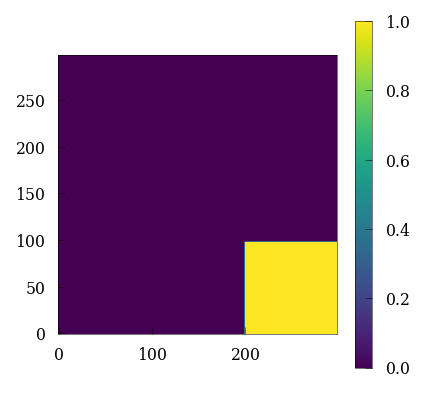

In [4]:
H, L = (299, 299)
Hmid = int(H / 2)
Lmid = int(L / 2)
r = int(H / 3)

structure = np.zeros((H, L))
structure[:r, -r:] += rectangle(r, r)


plt.figure(figsize=(3, 3))
cb = plt.imshow(structure, origin="lower")
plt.colorbar(cb)
plt.show()

In [5]:
ndim = len(structure.shape)
N = structure.shape[0]

# grid dimensions
shape = [N, N]  # number of voxels in all directions

We also define certain Identity tensor for each grid point.

- $\mathbf{I}$ = 2 order Identity tensor with shape `(2, 2, N, N)` 
- $\mathbb{I4}$ = 4 order Identity tensor with shape `(2, 2, 2, 2, N, N)`


In [6]:
# identity tensor (single tensor)
i = jnp.eye(ndim)

# identity tensors (grid)
I = jnp.einsum("ij,xy", i, jnp.ones([N, N]))  # 2nd order Identity tensor
I4 = jnp.einsum(
    "ijkl,xy->ijklxy", jnp.einsum("il,jk", i, i), jnp.ones([N, N])
)  # 4th order Identity tensor
I4rt = jnp.einsum("ijkl,xy->ijklxy", jnp.einsum("ik,jl", i, i), jnp.ones([N, N]))
I4s = (I4 + I4rt) / 2.0

II = tensor.dyad22(I, I)

## assigning material parameters 
We assign material parameters to the two phases. The two phases within the RVE are denoted as
- Soft = 0
- Hard = 1

In [7]:
# material parameters + function to convert to grid of scalars
@functools.partial(jax.jit, static_argnames=["soft", "hard"])
def param(X, soft, hard):
    return soft * jnp.ones_like(X) * (X) + hard * jnp.ones_like(X) * (1 - X)

In [8]:
# material parameters
elastic_modulus = {"hard": 5.7, "soft": 0.57}  # N/mm2
poisson_modulus = {"hard": 0.386, "soft": 0.386}

# lames constant
lambda_modulus = {}
shear_modulus = {}
bulk_modulus = {}

for key in elastic_modulus.keys():
    lambda_modulus[key] = (
        poisson_modulus[key]
        * elastic_modulus[key]
        / ((1 + poisson_modulus[key]) * (1 - 2 * poisson_modulus[key]))
    )

    shear_modulus[key] = elastic_modulus[key] / (2 * (1 + poisson_modulus[key]))

    bulk_modulus[key] = lambda_modulus[key] + 2 * shear_modulus[key] / 3

In [9]:
# material parameters
K = param(
    structure, soft=bulk_modulus["soft"], hard=bulk_modulus["hard"]
)  # bulk      modulus
μ0 = param(
    structure, soft=shear_modulus["soft"], hard=shear_modulus["hard"]
)  # shear     modulus
λ0 = param(
    structure, soft=lambda_modulus["soft"], hard=lambda_modulus["hard"]
)  # shear     modulus

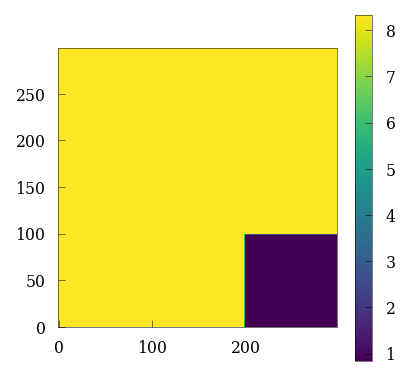

In [10]:
plt.figure(figsize=(3, 3))
plt.imshow(K, origin="lower")
plt.colorbar()
plt.show()

In [11]:
Ghat4_2 = compute_Ghat_4_2(NN=(N,) * ndim, operator="fourier", length=1.0)

In [12]:
# (inverse) Fourier transform (for each tensor component in each direction)
@jax.jit
def fft(x):
    return jnp.fft.fftshift(jnp.fft.fftn(jnp.fft.ifftshift(x), [N, N]))


@jax.jit
def ifft(x):
    return jnp.fft.fftshift(jnp.fft.ifftn(jnp.fft.ifftshift(x), [N, N]))


# functions for the projection 'G', and the product 'G : K : dF'
@jax.jit
def G(A2):
    return jnp.real(ifft(tensor.ddot42(Ghat4_2, fft(A2)))).reshape(-1)


@jax.jit
def K_dF(dF, K4):
    # jax.debug.print('x={}', K4)
    return tensor.trans2(tensor.ddot42(K4, tensor.trans2(dF.reshape(ndim, ndim, N, N))))


@jax.jit
def G_K_dF(dF, K4):
    return G(K_dF(dF, K4))

## st-venant kirchhoff material

The strain energy function for a `St. Venant Kirchhoff` material (isotropic compresisble hyperelastic material) is given as 
\begin{align}
\psi(E) &= \dfrac{\lambda}{2}(\text{tr} E)^2 + \mu \text{tr}(E:E) \\ 
\end{align}

where `E= Green-Lagrange strain tensor` which can be related to the `deformation gradient F` as 
\begin{align}
E = \dfrac{1}{2}(F^{T}.F -I)
\end{align}

In [13]:
@jax.jit
def green_lagrange_strain(F: ArrayLike) -> Array:
    return 0.5 * (tensor.dot22(tensor.trans2(F), F) - I)


@jax.jit
def strain_energy(F: ArrayLike) -> Array:
    E = green_lagrange_strain(F)
    E = 0.5 * (E + tensor.trans2(E))
    energy = 0.5 * jnp.multiply(λ0, tensor.trace2(E) ** 2) + jnp.multiply(
        μ0, tensor.trace2(tensor.dot22(E, E))
    )
    return energy.sum()


piola_kirchhoff = jax.jit(jax.jacrev(strain_energy))

Due to the `geometric nonlinearity` in the stress-strain relationship, we use a `Netwon-Raphson` scheme combined with `Conjugate gradient` to solve for the compatible strains within the RVE. 
\begin{align}
    \Delta \sigma_{ij} = \dfrac{\partial \sigma_{ij}(F)}{\partial F_{ij}}\Delta F_{ij}
\end{align}

In [14]:
@functools.partial(jax.jit, static_argnames=["piola_kirchhoff"])
def G_P(dF, additional, piola_kirchhoff):
    dF = dF.reshape(ndim, ndim, N, N)
    tangents = jax.jvp(piola_kirchhoff, (additional,), (dF,))[1]
    return G(tangents)

## conjugate-Gradient solver
Here we define the conjugate gradient solver for `Newton-Krylov` solver

In [15]:
@functools.partial(jax.jit, static_argnames=["A", "K"])
def conjugate_gradient(A, b, additional, K, atol=1e-5):

    b, additional = jax.device_put((b, additional))
    iiter = 0

    def body_fun(state):
        b, p, r, rsold, x, iiter = state
        Ap = A(p, additional, K)
        alpha = rsold / jnp.vdot(p, Ap)
        x = x + jnp.dot(alpha, p)
        r = r - jnp.dot(alpha, Ap)
        rsnew = jnp.vdot(r, r)
        p = r + (rsnew / rsold) * p
        rsold = rsnew
        iiter += 1
        return (b, p, r, rsold, x, iiter)

    def cond_fun(state):
        b, p, r, rsold, x, iiter = state
        return jnp.sqrt(rsold) > atol

    x = jnp.zeros_like(b)
    r = b - A(x, additional, K)

    p = r
    rsold = jnp.vdot(r, r)

    b, p, r, rsold, x, iiter = jax.lax.while_loop(
        cond_fun, body_fun, (b, p, r, rsold, x, iiter)
    )
    return x, iiter

## newton raphson method

Here we define a function to solve the hyperelasticity problem using a `newton-raphson` method

In [16]:
@jax.jit
def solve_netwon_raphson(state, n):
    dF, b, F, Fn, iiter = state

    error = jnp.linalg.norm(dF) / Fn
    jax.debug.print("residual={}", error)

    def true_fun(state):
        dF, b, F, Fn, iiter = state

        dF, iiter_cg = conjugate_gradient(
            atol=1e-8,
            A=G_P,
            b=b,
            additional=F,
            K=piola_kirchhoff,
        )  # solve linear system using CG

        dF = dF.reshape(ndim, ndim, N, N)
        F = jax.lax.add(F, dF)  # update DOFs (array -> tens.grid)
        P = piola_kirchhoff(F)  # new residual stress
        b = -G(P)  # convert residual stress to residual
        iiter = iiter.at[n, 0].set(iiter_cg)
        iiter = iiter.at[n, 1].set(jnp.linalg.norm(dF) / Fn)

        return (dF, b, F, Fn, iiter)

    def false_fun(state):
        dF, b, F, Fn, iiter = state

        iiter = iiter.at[n, 1].set(jnp.linalg.norm(dF) / Fn)

        return (dF, b, F, Fn, iiter)

    return jax.lax.cond(error > 1e-6, true_fun, false_fun, state), n

## solving for a given loaded state 

In [17]:
F = jnp.array(I, copy=True)
P = piola_kirchhoff(F)

# set macroscopic loading
DbarF = jnp.zeros([ndim, ndim, N, N])
DbarF = DbarF.at[0, 1].add(0.1)

# initial residual: distribute "barF" over grid using "K"
b = -G_P(DbarF, F, piola_kirchhoff)
F = jax.lax.add(F, DbarF)
Fn = jnp.linalg.norm(F)

In [18]:
iiter = jnp.zeros((10, 2))
state = (DbarF, b, F, Fn, iiter)
initial_state = jax.device_put(state)

In [19]:
import timeit
import tracemalloc

In [20]:
start_time = timeit.default_timer()
# starting the monitoring
tracemalloc.start()
final_state, xs = jax.lax.scan(
    solve_netwon_raphson, init=initial_state, xs=jnp.arange(0, 10)
)
# displaying the memory
print(tracemalloc.get_traced_memory()[1], "B")
final_time = timeit.default_timer()

# stopping the library
tracemalloc.stop()

print(final_time - start_time)

residual=0.0705345615858598
residual=0.04266048558240271
residual=0.003944334769314854
residual=0.0004563286113524589
residual=0.00017426322527736642
residual=2.8069814714984273e-05
residual=6.41294672669963e-07
residual=6.41294672669963e-07
residual=6.41294672669963e-07
residual=6.41294672669963e-07
50842202 B
28.770045453915372


Reading the convergence results from the analytical implementation of hyperelastic material.

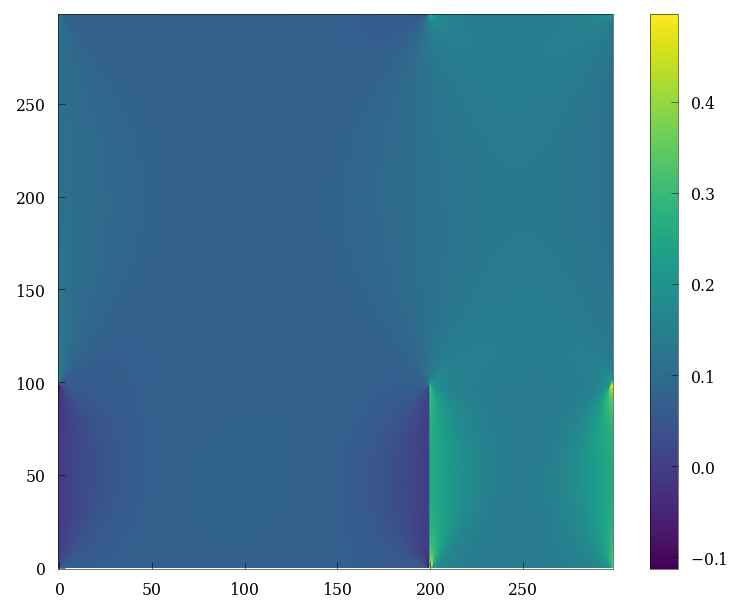

In [21]:
plt.imshow(final_state[2].at[0, 1].get(), origin="lower")
plt.colorbar()

In [22]:
normal_hyper_convergence = np.loadtxt("./additional_data/normal-hyperelasticity.txt")

In [23]:
from matplotlib.gridspec import GridSpec

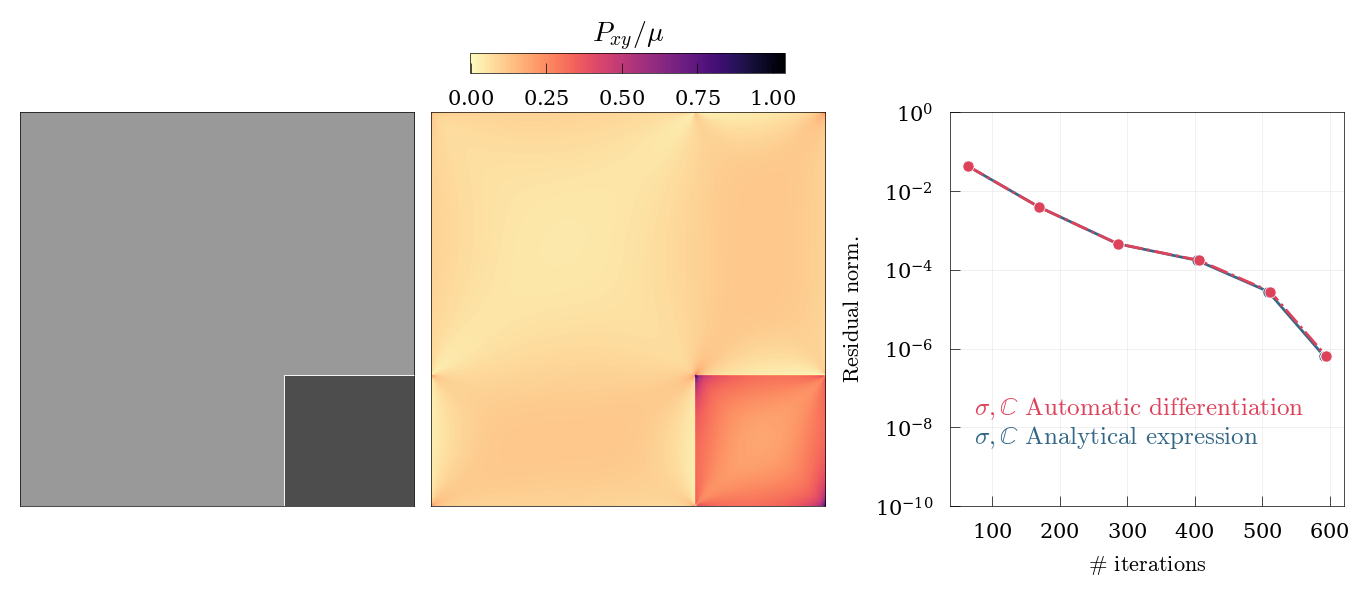

In [38]:
colors  ={'ad' : '#de425b', 'standard' :  '#346888' }

fig = plt.figure(
    figsize=set_size(width="two-column", fraction=0.95, height_ratio=0.42),
    constrained_layout=True,
    dpi=200,
)
gs1 = GridSpec(1, 3, figure=fig, width_ratios=[1, 1, 1])
ax = fig.add_subplot(gs1[0, 0])


ax.imshow(1 - structure, alpha=0.4, cmap="Greys", zorder=30, origin="lower")
ax.imshow(
    np.ma.array(structure[:, :], mask=1 - structure),
    alpha=0.7,
    cmap="Greys_r",
    zorder=30,
    origin="lower",
)

ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)


ax = fig.add_subplot(gs1[0, 1])
P = piola_kirchhoff(final_state[2])
cs = ax.imshow(P.at[0, 1].get() / μ0, origin="lower", cmap="magma_r")
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

axins1 = ax.inset_axes([0.1, 1.1, 0.8, 0.05])

cbar = fig.colorbar(
    cs, cax=axins1, pad=0.05, fraction=0.025, shrink=0.5, orientation="horizontal"
)
cbar.set_label(r"$P_{xy}/\mu$", fontsize=10, labelpad=-32, y=0.85)
cbar.ax.yaxis.set_offset_position("right")
ax.set_aspect(1 / ax.get_data_ratio())

ax = fig.add_subplot(gs1[0, 2])

ax.semilogy(
    np.cumsum(final_state[-1].at[:, 0].get()),
    final_state[-1].at[:, 1].get(),
    marker="o",
    color=colors['ad'],
    markeredgecolor="w",
    ls='dashdot',
    label=r"$\mathbb{C}~\text{Automatic differentiation}$",
)
ax.semilogy(
    np.cumsum(normal_hyper_convergence[:-1, 0]),
    normal_hyper_convergence[:-1, 1],
    marker="o",
    markeredgecolor="w",
    color=colors['standard'],
    label=r"$\mathbb{C}~\text{Analytical expression}$",
    ls="solid", zorder=-1
)
ax.set_ylim(top=1, bottom=1e-10)
ax.set_ylabel(r"$\text{Residual norm.}$")
ax.set_xlabel(r"$\text{# iterations}$")
ax.text(
    0.06,
    0.25,
    r"$\sigma, \mathbb{C}~\text{Automatic differentiation}$",
    horizontalalignment="left",
    color=colors['ad'],
    verticalalignment="center",
    transform=ax.transAxes,
    fontsize=9,
)
ax.text(
    0.06,
    0.175,
    r"$\sigma, \mathbb{C}~\text{Analytical expression}$",
    horizontalalignment="left",
    color=colors['standard'],
    verticalalignment="center",
    transform=ax.transAxes,
    fontsize=9,
)

ax.grid(which="both", linestyle='solid', alpha=0.15)
# ax.legend(frameon=False, loc='best')
ax.set_aspect(1 / ax.get_data_ratio())
#ax.set_ylim(bottom=1e-8)

plt.savefig('./figs/paper_st_venant_comparison.svg')
plt.show()